<a href="https://www.kaggle.com/code/kavishchaudhary1003/playground-s3-e14-optuna-xgb-lgbm-catboost?scriptVersionId=129325285" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [24]:
import numpy as np
import pandas as pd 
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm
from sklearn.metrics import mean_squared_error



import os
for dirname, _, filenames in os.walk('/kaggle/input/playground-series-s3e14'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/playground-series-s3e14/sample_submission.csv
/kaggle/input/playground-series-s3e14/train.csv
/kaggle/input/playground-series-s3e14/test.csv


# Competition Page
https://www.kaggle.com/competitions/playground-series-s3e14

In [25]:
train = pd.read_csv('/kaggle/input/playground-series-s3e14/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e14/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e14/sample_submission.csv')

### Drop id from train and test set

In [26]:
train.drop(columns = ['id'], inplace = True)
test.drop(columns = ['id'], inplace = True)

### Checking for null and duplicates

In [27]:
train.isna().sum()
train.duplicated().sum()
train.drop_duplicates(inplace = True)
train.reset_index(drop= True, inplace = True)

In [28]:
for i in train.columns:
    print(train[i].value_counts())

25.0    8243
12.5    6714
37.5     263
20.0      56
10.0       4
40.0       2
Name: clonesize, dtype: int64
0.500     7830
0.250     7282
0.750      108
0.537       38
0.000       16
18.430       5
6.640        3
Name: honeybee, dtype: int64
0.250    10851
0.380     4374
0.117       39
0.000        5
0.042        3
0.058        2
0.065        2
0.585        2
0.293        2
0.560        1
0.260        1
Name: bumbles, dtype: int64
0.380    4565
0.500    4163
0.630    3040
0.750    1828
0.250    1621
0.409      43
0.000       8
0.229       4
0.490       2
0.147       2
0.707       1
0.240       1
0.560       1
0.101       1
0.234       1
0.235       1
Name: andrena, dtype: int64
0.630    4762
0.500    4698
0.750    4384
0.250     870
0.380     509
0.058      42
0.000       6
0.021       4
0.117       2
0.620       1
0.585       1
0.020       1
0.078       1
0.606       1
Name: osmia, dtype: int64
86.0    4197
77.4    3786
94.6    3733
69.7    3563
89.0       2
79.0       1
Name: MaxOfUp

### Summary stats

In [29]:
train.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000,15282.000000
mean,19.703082,0.389280,0.286768,0.492704,0.592373,82.169762,49.673204,68.656144,59.229446,28.660509,48.568427,18.660513,0.324168,0.502753,0.446555,36.165176,6025.329057
std,6.592528,0.361695,0.059917,0.148102,0.139446,9.147368,5.546810,7.642362,6.611121,3.195599,5.390940,11.656480,0.163887,0.074351,0.037019,4.029179,1336.479361
min,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510
50%,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506473,0.446570,36.040675,6117.475900
75%,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380
max,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401840


### Co relation heat map

In [30]:
corr = train[[ 'fruitset', 'fruitmass', 'seeds',
       'yield']].corr()
corr.style.background_gradient(cmap = 'coolwarm')

,fruitset,fruitmass,seeds,yield
fruitset,1.000000,0.936928,0.929575,0.885814
fruitmass,0.936928,1.000000,0.931557,0.826269
seeds,0.929575,0.931557,1.000000,0.868685
yield,0.885814,0.826269,0.868685,1.000000


### Plotting the  continuous predictor variables

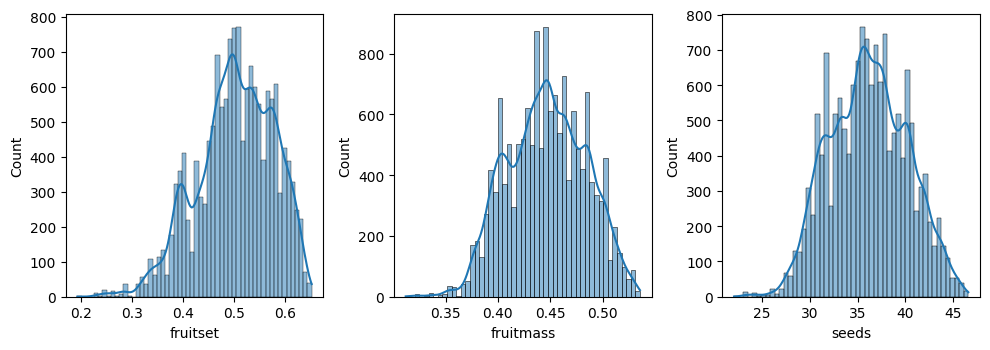

In [31]:
plt.figure(figsize = (10,10))
for i in range(len(['fruitset', 'fruitmass', 'seeds'])):
    plt.subplot(3,3,i+1)
    sns.histplot(x= train[(['fruitset', 'fruitmass', 'seeds'])[i]], kde = True)
    plt.tight_layout()

### Plotting the boxplot of continuous predictor variables

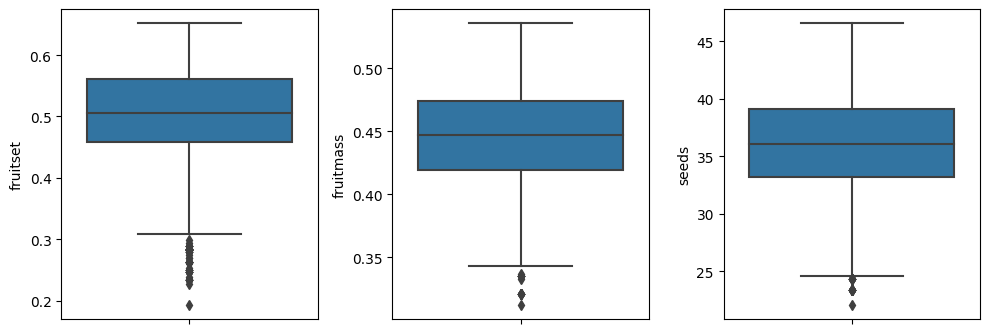

In [32]:
plt.figure(figsize = (10,10))
for i in range(len(['fruitset', 'fruitmass', 'seeds'])):
    plt.subplot(3,3,i+1)
    sns.boxplot(y = train[(['fruitset', 'fruitmass', 'seeds'])[i]])
    plt.tight_layout()

### Plotting the categorical variables

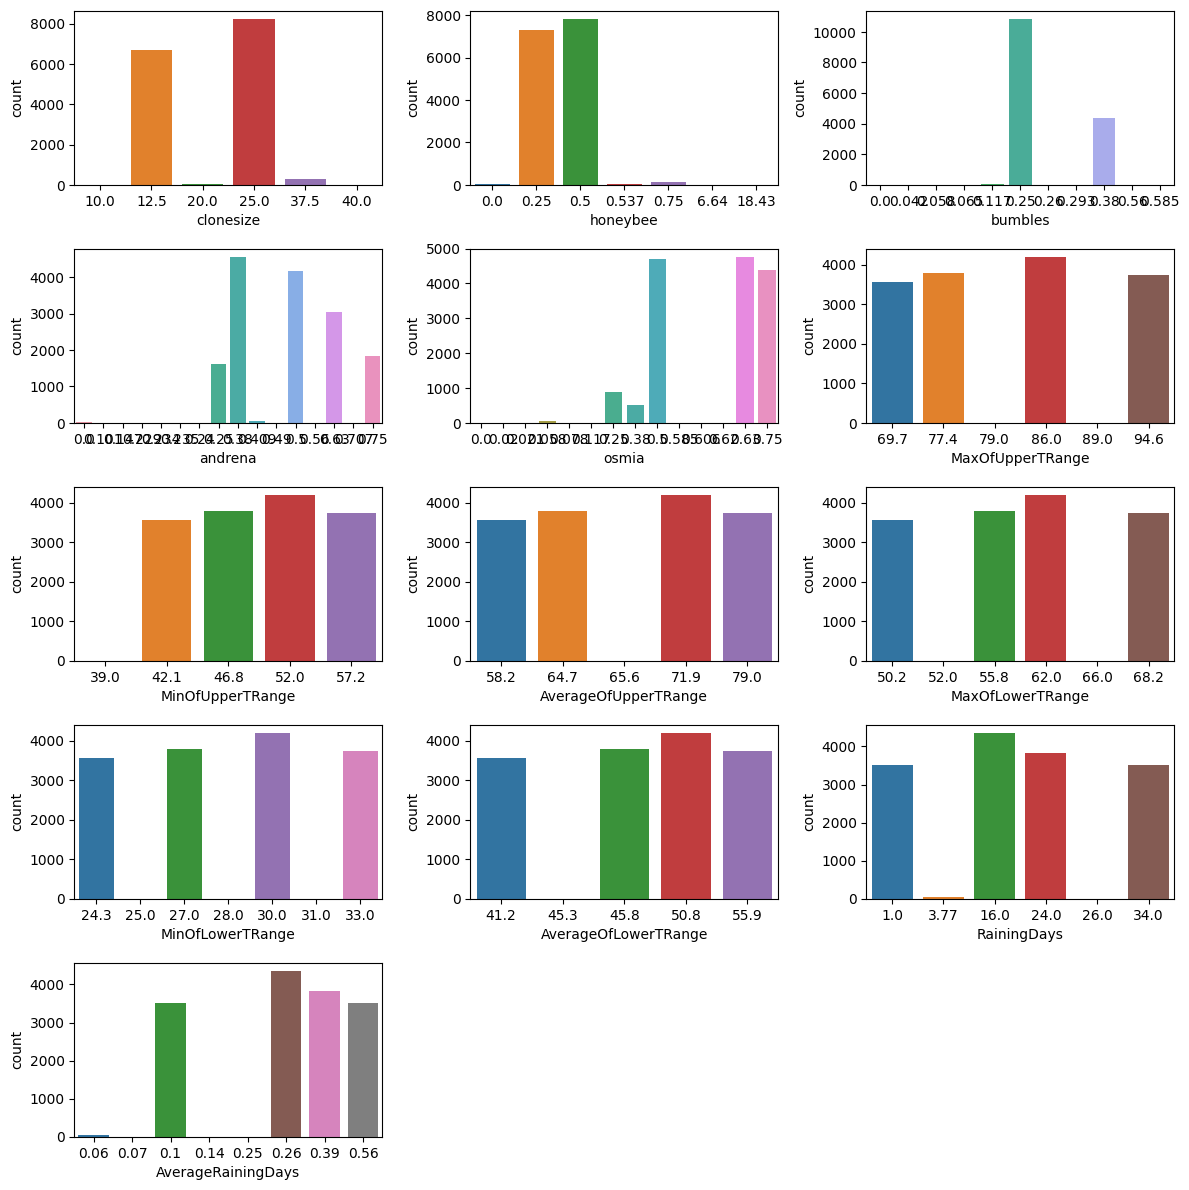

In [33]:
plt.figure(figsize= (12,12))
for i in range(len(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays'])):
    plt.subplot(5,3, i+1)
    sns.countplot(x = train[(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays'])[i]])
    plt.tight_layout()

### Plotting the target variable

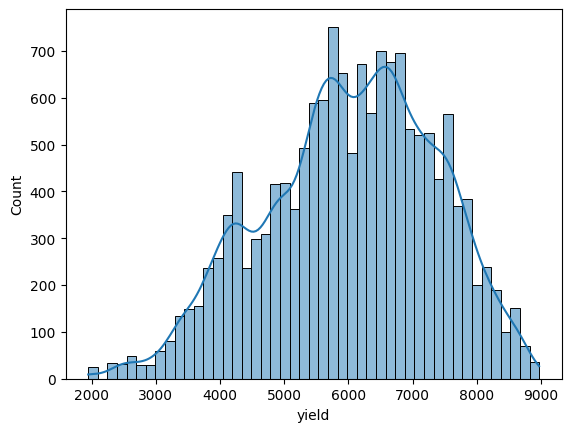

In [34]:
sns.histplot(x = train['yield'], kde = True)
plt.show()

### Separating features and target variable

In [6]:
y = train['yield']
train.drop(columns = ['yield'], inplace = True)

### Optuna parameter tuning- XG Boost

In [8]:
def obj_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth',1,10),
        'learning_rate': trial.suggest_float('learning_rate',0.1,1),
        'n_estimators': trial.suggest_int('n_estimators',200,1000),
        'gamma': trial.suggest_float('gamma', 1e-5, 2),
        'min_child_weight': trial.suggest_int('min_child_weight',1,20),
        'subsample': trial.suggest_float('subsample', 0,1),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0,1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda',0,1)
        }
    scores = []
    optuna_model = XGBRegressor(**params)
    cv = KFold(n_splits = 10, random_state = 100, shuffle = True)
    for train_index, test_index in cv.split(train, y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx,trainy)
        predy = optuna_model.predict(testx)
        scores.append(mean_squared_error(testy, predy, squared = False))
    return np.mean(scores)
study_xgb = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
n_trials = 50
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_xgb.optimize(obj_xgb, n_trials = 1)
        pbar.update(1)
        

100%|██████████| 50/50 [23:26<00:00, 28.12s/it]  


### Optuna parameter tuning- Light GBM

In [12]:
def obj_light(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators',200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.1,1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0,1),
        'reg_alpha': trial.suggest_float('reg_alpha',0,1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    scores = []
    optuna_model = LGBMRegressor(**params)
    cv= KFold(n_splits = 10, shuffle = True, random_state = 100)
    for train_index, test_index in cv.split(train, y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx,trainy)
        predy= optuna_model.predict(testx)
        scores.append(mean_squared_error(testy,predy, squared = False))
    return np.mean(scores)
study_light = optuna.create_study(direction = 'minimize')
n_trials = 50
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_light.optimize(obj_light, n_trials = 1)
        pbar.update(1)

100%|██████████| 50/50 [10:24<00:00, 12.48s/it]


### Optuna parameter tuning- Cat Boost

In [15]:
def obj_cat(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'depth': trial.suggest_int('depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate',0,1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.01, 0.1)
    }
    scores = []
    optuna_model = CatBoostRegressor(**params, verbose = False)
    cv = KFold(n_splits = 10, shuffle = True, random_state = 100)
    for train_index, test_index in cv.split(train, y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx, trainy)
        predy = optuna_model.predict(testx)
        scores.append(mean_squared_error(testy,predy, squared = False))
    return np.mean(scores)
study_cat = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
n_trials = 50
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_cat.optimize(obj_cat, n_trials = 1)
        pbar.update(1)

100%|██████████| 50/50 [09:24<00:00, 11.29s/it]


In [20]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 100)
pred_xgb = np.zeros(test.shape[0])
pred_lgb = np.zeros(test.shape[0])
pred_cat = np.zeros(test.shape[0])
rmse_xgb = []
rmse_lgb = []
rmse_cat = []
n= 0
for train_index, test_index in cv.split(train, y):
    trainx, testx = train.iloc[train_index], train.iloc[test_index]
    trainy, testy = y[train_index], y[test_index] 
    
    model_xgb = XGBRegressor(**study_xgb.best_params)
    model_xgb.fit(trainx, trainy, eval_set = [(testx,testy)],early_stopping_rounds= 100, verbose = False)
    pred_xgb+= model_xgb.predict(test)/cv.n_splits
    rmse_xgb.append(mean_squared_error(testy,model_xgb.predict(testx), squared = False))
    
    model_lgb = LGBMRegressor(**study_light.best_params)
    model_lgb.fit(trainx, trainy,eval_set =[(testx,testy)],early_stopping_rounds= 100, verbose = False)
    pred_lgb+= model_lgb.predict(test)/ cv.n_splits
    rmse_lgb.append(mean_squared_error(testy, model_lgb.predict(testx), squared = False))
    
    model_cat = CatBoostRegressor(**study_cat.best_params)
    model_cat.fit(trainx, trainy,eval_set =[(testx,testy)],early_stopping_rounds= 100, verbose = False)
    pred_cat+= model_cat.predict(test)/ cv.n_splits
    rmse_cat.append(mean_squared_error(testy, model_cat.predict(testx), squared = False))
    
    print(f"fold: {n+1} RMSE xgb: {rmse_xgb[n]} | RMSE LGBM: {rmse_lgb[n]} | RMSE cat: {rmse_cat[n]} ")
    n+=1

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 1 RMSE xgb: 552.6804902355253 | RMSE LGBM: 554.1617846358052 | RMSE cat: 553.5599739947673 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 2 RMSE xgb: 565.9042993946 | RMSE LGBM: 567.1612766495667 | RMSE cat: 566.8575419327484 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 3 RMSE xgb: 573.8854657972284 | RMSE LGBM: 571.066019913995 | RMSE cat: 570.509464107802 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 4 RMSE xgb: 555.5374760205482 | RMSE LGBM: 557.4759386003609 | RMSE cat: 551.1677105163869 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 5 RMSE xgb: 539.1493198054427 | RMSE LGBM: 541.9616999382918 | RMSE cat: 540.2048695986695 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 6 RMSE xgb: 548.4074634305124 | RMSE LGBM: 545.4670673487205 | RMSE cat: 550.258938526811 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 7 RMSE xgb: 572.9293051752395 | RMSE LGBM: 571.1764517661669 | RMSE cat: 569.0639845890947 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 8 RMSE xgb: 557.3642525230254 | RMSE LGBM: 558.0614511134448 | RMSE cat: 563.4012043096742 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 9 RMSE xgb: 572.9589699189311 | RMSE LGBM: 572.7096223196364 | RMSE cat: 568.6044366286802 


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


fold: 10 RMSE xgb: 614.2899252058447 | RMSE LGBM: 616.5566398920292 | RMSE cat: 617.5868262750015 


In [21]:
submission['XGB'] = pred_xgb
submission['yield'] = submission['XGB']
final_submission = pd.DataFrame(submission, columns=['id', 'yield'])
final_submission.to_csv('predictions.csv', index = False)

# The Best model

In [22]:
submission['LGBM'] = pred_lgb
submission['yield'] = submission['LGBM']
final_submission = pd.DataFrame(submission, columns=['id', 'yield'])
final_submission.to_csv('predictions.csv', index = False)

In [23]:
submission['CAT'] = pred_cat
submission['yield'] = submission['CAT']
final_submission = pd.DataFrame(submission, columns=['id', 'yield'])
final_submission.to_csv('predictions.csv', index = False)